Vignesh Ramakrishnan




21310037 






ME639 Robotics Miniproject


In [2]:
#Vignesh Ramakrishnan
#21310037
#Importing libraries
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate 
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
from matplotlib import rc
from IPython.display import HTML
from numpy import sin, cos,arctan,arccos
from collections import deque

In [3]:
#Some fixed values for our system
l1 = 0.5
l2 = 0.5
m1 = 1
m2 = 2
i1 = m1* (l1**2)/3
i2 = m2* (l2**2)/3
g  = 9.8

#Some simulation parameters
tmax=10
dt=0.02
frames_count=1000


In [4]:
#Some motion control and some force control utilities

#Kinematics 

def EndEffectorPosFromAngles(q1,q2):
  x=(l1* np.cos(q1))+(l2*np.cos(q2))
  y=(l1*np.sin(q1))+(l2*np.sin(q2))
  return np.array([x,y])

def jointLocFromAngle(q1,q2):
  xjoint=l1* np.cos(q1)
  yjoint=l1*np.sin(q1)
  return np.array([xjoint,yjoint])
#print(EndEffectorPosFromAngles(np.pi/9,np.pi/6))

def VeloCalcFromAngularVelo(q1dot,q2dot,q1,q2):
  jacobian= np.array([[-l1*np.sin(q1),-l2*np.sin(q2)],[l1* np.cos(q1),l2*np.cos(q2)]])
  [xdot,ydot]=np.array(np.dot(jacobian,[q1dot,q2dot]))
  return np.array([xdot,ydot])

#inverse kinematics
def AnglesFromEndEffectorPos(x,y):
  alpha= np.arccos(((x**2)+(y**2)-(l1**2)-(l2**2))/(2*l1*l2))
  q1=(np.arctan2(y,x)- np.arctan2((l2*sin(alpha)),(l1+(l2*cos(alpha)))))
  q2=q1+alpha
  return np.array([q1,q2])
#print(AnglesFromEndEffectorPos(1.80571802,0.84202014))

def AngularVeloCalcFromVelo(xdot,ydot,q1,q2):
  jacobian= np.array([[-l1*np.sin(q1),-l2*np.sin(q2)],[l1* np.cos(q1),l2*np.cos(q2)]])
  invjacobian= np.linalg.inv(jacobian)
  [q1dot,q2dot]=np.dot(invjacobian,[xdot,ydot])
  return np.array([q1dot,q2dot])

# angle difference in the range -pi to +pi
def thetadiffmin(theta1, theta2):
  return (theta1 - theta2 + np.pi) % (2 * np.pi) - np.pi

#Joint and End Effector Torques from component end effector forces
def TauFromF(Fx,Fy,q1,q2):
  tau1=(Fy*l1*np.cos(q1))+(Fx*l1*np.sin(q1))
  tau2=(Fy*l2*np.cos(q2))+(Fx*l2*np.sin(q2))
  return np.array([tau1,tau2])

In [5]:
#Trajectory tracking animation
#targetpos [xtarget,ytarget]
initq1=0.0
initq2=0.0
initpos=[initq1,initq2]
resultangles=[initpos]
dt=0.02
q1dot=2
q2dot=1
def trajtrack(targetpos,initpos):
  currentpos=initpos
  while(np.linalg.norm(np.array(targetpos)-np.array(currentpos)))>0.1:
    #print(np.linalg.norm(np.array(targetpos)-np.array(currentpos)),'error')
    xt=targetpos[0]
    yt=targetpos[1]
    x=currentpos[0]
    y=currentpos[1]
    targetangleset=AnglesFromEndEffectorPos(xt,yt)
    currentangleset=AnglesFromEndEffectorPos(x,y)
    
    if np.sqrt(xt**2 + yt**2) > (l1 + l2):
      targetangleset[0]=initq1
      targetangleset[1]=initq2
    if targetangleset[0]<0 :
      targetangleset[1]=-targetangleset[1]
      alpha= np.arccos(((xt**2)+(yt**2)-(l1**2)-(l2**2))/(2*l1*l2))
      targetangleset[0]=(np.arctan2(yt,xt)- np.arctan2((l2*sin(alpha)),(l1+(l2*cos(alpha)))))
  

    jointAngleError=thetadiffmin(targetangleset[0],currentangleset[0])
    endEffectorAngleError=thetadiffmin(targetangleset[1],currentangleset[1])


    currentangleset[0]=currentangleset[0]+ jointAngleError*q1dot*dt
    currentangleset[1]=currentangleset[1]+ endEffectorAngleError*q2dot*dt
   
    Nextjoint=jointLocFromAngle(currentangleset[0],currentangleset[1])
    Nextend=EndEffectorPosFromAngles(currentangleset[0],currentangleset[1])
    currentpos[0]=Nextend[0]
    currentpos[1]=Nextend[1]


    resultangles.append((currentangleset).tolist())
    #print(resultangles,'resultangles')
  return np.array(resultangles)
  



Task 1: position tracking

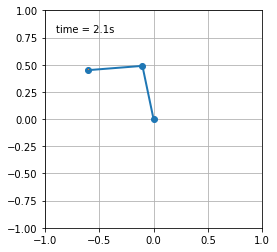

In [6]:
#Plotting Task 1 Animation
#def plotterposition():
Targetposition=[-l1-0.2*l2,l1+0.1*l2]
resultangles=trajtrack(Targetposition,initpos) 
endeff=EndEffectorPosFromAngles(resultangles[:,0],resultangles[:,1])
joint=jointLocFromAngle(resultangles[:,0],resultangles[:,1])


fig0 = plt.figure(figsize=(5,4))
ax = fig0.add_subplot(111,autoscale_on=False, xlim=(-(l1+l2), (l1+l2)), ylim=(-(l1+l2), 1.))
ax.set_aspect('equal')
ax.grid()

line, = ax.plot([], [], 'o-', lw=2)
trace, = ax.plot([], [], ',-', lw=1)
time_template = 'time = %.1fs'
time_text = ax.text(0.05, 0.9, 's', transform=ax.transAxes)
dt=0.02
framescount=1000
def frameBuild(i):
  robot_pos_x=[0,joint[0,i],endeff[0,i]]
  robot_pos_y=[0,joint[1,i],endeff[1,i]]
  frames_x, frames_y = deque(maxlen=framescount), deque(maxlen=framescount)
  if i == 0:
        frames_x.clear()
        frames_y.clear()
  frames_x.appendleft(robot_pos_x[2])
  frames_y.appendleft(robot_pos_y[2])

  line.set_data(robot_pos_x, robot_pos_y)
  trace.set_data(frames_x, frames_y)
  time_text.set_text(time_template % (i*dt))
  return (line, trace, time_text)

anim_pos = animation.FuncAnimation(fig0, frameBuild, len(resultangles), interval=dt*1000, blit=True)
HTML(anim_pos.to_html5_video())

In [7]:
#Trying to consider dynamics of system for torque control
#states=[q1,q1dot,q2,q2dot]
def xdotCalc(state,t,tau1,tau2):
  dstate=np.zeros_like(state)
  #angular position states
  q1=state[0]
  q2=state[2]
  #angular velocity states
  q1dot=state[1]
  q2dot=state[3]
  #From equation 6, we find angular acceleration as function of torques 
  A=(m1*(l1**2)/3)+m2*(l1**2)
  B=(m2*l1*l2/2)*np.cos(q2-q1)
  C=(m2*l1*l2*(q1dot**2)*np.sin(q2-q1))+(m1*g*l1*np.cos(q1)/2)+(m2*g*l1*np.cos(q1))
  D= (m2*l1*l2*np.cos(q2-q1)/2)
  E=m2*(l2**2)/3
  F=(m2*l1*l2*(q1dot**2)*np.sin(q2-q1)/2)+(m2*g*l2*np.cos(q2)/2)


  q1ddot=((E*tau1-B*tau2)-(C*E)+(B*F))/((E*A)-(B*D))
  q2ddot=((D*tau1-A*tau2)-(C*D)+(A*F))/((D*B)-(A*E))
  #to cancel acceleration dynamics put tau1=C, tau2=F

  #Setting up state derivatives
  dstate[0]=q1dot
  dstate[1]=q1ddot
  dstate[2]=q2dot
  dstate[3]=q2ddot
  return dstate.tolist()



Task T2: Reaching a particular position and applying constant force at the position

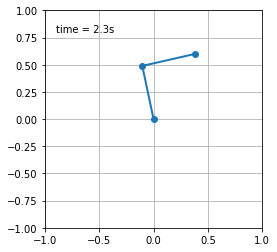

In [8]:
#For Task T2 some simulation parameters
#Please run all the blocks above in same order before running this in order to initialize variables.
dt=0.02
tmax=10
t=np.linspace(0,dt,tmax)
Fx=10
Fy=15
#initq1=0.0
#initq2=0.0
#initpos=[initq1,initq2]
Wall=Targetposition
#resultangles_posControl=list(initpos)
resultangles_posControl=trajtrack(Wall,initpos)
#resultangles_posControl=resultangles_posControl.tolist()
[q1,q2]=resultangles_posControl[-1]
#print(anglediff())

tau_val=TauFromF(Fx,Fy,q1,q2)
tau1=tau_val[0]
tau2=tau_val[1]
resultangles=resultangles_posControl.tolist()
state=[q1,0,q2,0]
resultangles_forcecontrol=integrate.odeint(xdotCalc, state, t,args=(tau1,tau2))
for i in resultangles:
  i.insert(1,0)
  i.append(0)

resultangles[len(resultangles):]=resultangles_forcecontrol.tolist()
#print(resultangles)
resultangles=np.array(resultangles);
endeff=EndEffectorPosFromAngles(resultangles[:,0],resultangles[:,1])
joint=jointLocFromAngle(resultangles[:,0],resultangles[:,1])


fig0 = plt.figure(figsize=(5,4))
ax = fig0.add_subplot(111,autoscale_on=False, xlim=(-(l1+l2), (l1+l2)), ylim=(-(l1+l2), 1.))
ax.set_aspect('equal')
ax.grid()

line, = ax.plot([], [], 'o-', lw=2)
trace, = ax.plot([], [], 'k-', lw=1)
time_template = 'time = %.1fs'
time_text = ax.text(0.05, 0.9, 's', transform=ax.transAxes)
dt=0.02
framescount=1000
def frameBuild(i):
  robot_pos_x=[0,joint[0,i],endeff[0,i]]
  robot_pos_y=[0,joint[1,i],endeff[1,i]]
  frames_x, frames_y = deque(maxlen=framescount), deque(maxlen=framescount)
  if i == 0:
        frames_x.clear()
        frames_y.clear()
  frames_x.appendleft(robot_pos_x[2])
  frames_y.appendleft(robot_pos_y[2])

  line.set_data(robot_pos_x, robot_pos_y)
  trace.set_data(frames_x, frames_y)
  time_text.set_text(time_template % (i*dt))
  return (line, trace, time_text)

anim_pos1 = animation.FuncAnimation(fig0, frameBuild, len(resultangles), interval=dt*1000, blit=True)
HTML(anim_pos1.to_html5_video())

In [9]:
#Dynamics for T3 involve intraODE Torque updates
#states=[q1,q1dot,q2,q2dot]
def xdotCalcForSpring(state,t,tau1,tau2,springloc,Kx_spring,Ky_spring):
  dstate=np.zeros_like(state)
  #angular position states
  q1=state[0]
  q2=state[2]
  #angular velocity states
  q1dot=state[1]
  q2dot=state[3]
  #From equation 6, we find angular acceleration as function of torques 
  A=(m1*(l1**2)/3)+m2*(l1**2)
  B=(m2*l1*l2/2)*np.cos(q2-q1)
  C=(m2*l1*l2*(q1dot**2)*np.sin(q2-q1))+(m1*g*l1*np.cos(q1)/2)+(m2*g*l1*np.cos(q1))
  D= (m2*l1*l2*np.cos(q2-q1)/2)
  E=m2*(l2**2)/3
  F=(m2*l1*l2*(q1dot**2)*np.sin(q2-q1)/2)+(m2*g*l2*np.cos(q2)/2)


  q1ddot=((E*tau1-B*tau2)-(C*E)+(B*F))/((E*A)-(B*D))
  q2ddot=((D*tau1-A*tau2)-(C*D)+(A*F))/((D*B)-(A*E))
  #to cancel acceleration dynamics putting tau1=C, tau2=F
  tau1=C
  tau2=F

  x0=springloc[0]
  y0=springloc[1]
  currentloc=EndEffectorPosFromAngles(q1,q2)
  xcurrent=currentloc[0]
  ycurrent=currentloc[1]
  xdiff=xcurrent-x0
  ydiff=ycurrent-y0
  Fx=Kx_spring*xdiff
  Fy=Ky_spring*ydiff
  tau_val=TauFromF(Fx,Fy,q1,q2)

  #Now the cool part: Springy torques
  tau1=tau1+tau_val[0]
  tau2=tau2+tau_val[1]

  #Setting up state derivatives
  dstate[0]=q1dot
  dstate[1]=q1ddot
  dstate[2]=q2dot
  dstate[3]=q2ddot
  return dstate.tolist()

Task T3: Spring-like behaviour for end-effector

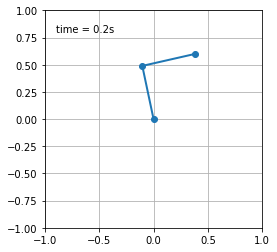

In [10]:
#Plotting Task 3 Animation

#Some simulation parameters
dt=0.02
tmax=10
t=np.linspace(0,dt,tmax)
springloc=np.array([l1*0.5+l2*0.5,l1*0.6+l2*0.6])
Kx_spring=-1
Ky_spring=-4
state=[q1,0,q2,0]
resultangles=integrate.odeint(xdotCalcForSpring, state, t,args=(tau1,tau2,springloc,Kx_spring,Ky_spring))
resultangles=resultangles.tolist()
resultangles=np.array(resultangles);
endeff=EndEffectorPosFromAngles(resultangles[:,0],resultangles[:,1])
joint=jointLocFromAngle(resultangles[:,0],resultangles[:,1])


fig0 = plt.figure(figsize=(5,4))
ax = fig0.add_subplot(111,autoscale_on=False, xlim=(-(l1+l2), (l1+l2)), ylim=(-(l1+l2), 1.))
ax.set_aspect('equal')
ax.grid()

line, = ax.plot([], [], 'o-', lw=2)
trace, = ax.plot([], [], 'k-', lw=1)
time_template = 'time = %.1fs'
time_text = ax.text(0.05, 0.9, 's', transform=ax.transAxes)
dt=0.02
framescount=1000
def frameBuild(i):
  robot_pos_x=[0,joint[0,i],endeff[0,i]]
  robot_pos_y=[0,joint[1,i],endeff[1,i]]
  frames_x, frames_y = deque(maxlen=framescount), deque(maxlen=framescount)
  if i == 0:
        frames_x.clear()
        frames_y.clear()
  frames_x.appendleft(robot_pos_x[2])
  frames_y.appendleft(robot_pos_y[2])

  line.set_data(robot_pos_x, robot_pos_y)
  trace.set_data(frames_x, frames_y)
  time_text.set_text(time_template % (i*dt))
  return (line, trace, time_text)

anim_pos1 = animation.FuncAnimation(fig0, frameBuild, len(resultangles), interval=dt*1000, blit=True)
HTML(anim_pos1.to_html5_video())

Task T4: End Effector sweep from 35 degrees to 145 degrees

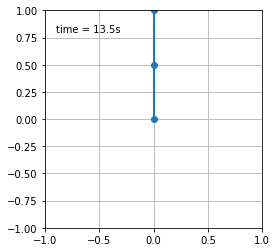

In [11]:
#Plotting Task 4 Animation
resultangles=([[np.radians(35),np.radians(35)]])
#def plotterposition():
p=np.arange(np.radians(35),np.radians(145),dt*thetadiffmin(np.radians(145),np.radians(35))*thetadiffmin(np.radians(145),np.radians(35)))
p1=np.arange(np.radians(35),np.radians(145),dt*thetadiffmin(np.radians(145),np.radians(35)))
for i in range(0,len(p)-1):
  for j in range(0,len(p)-1):
    resultangles.append([p1[i],p1[j]])
    #print(resultangles[i])
#print(resultangles)
resultangles=np.array(resultangles);
endeff=EndEffectorPosFromAngles(resultangles[:,0],resultangles[:,1])
joint=jointLocFromAngle(resultangles[:,0],resultangles[:,1])


fig0 = plt.figure(figsize=(5,4))
ax = fig0.add_subplot(111,autoscale_on=False, xlim=(-(l1+l2), (l1+l2)), ylim=(-(l1+l2), 1.))
ax.set_aspect('equal')
ax.grid()

line, = ax.plot([], [], 'o-', lw=2)
trace, = ax.plot([], [], 'k-', lw=1)
time_template = 'time = %.1fs'
time_text = ax.text(0.05, 0.9, 's', transform=ax.transAxes)
dt=0.02
framescount=1000
def frameBuild(i):
  robot_pos_x=[0,joint[0,i],endeff[0,i]]
  robot_pos_y=[0,joint[1,i],endeff[1,i]]
  frames_x, frames_y = deque(maxlen=framescount), deque(maxlen=framescount)
  if i == 0:
        frames_x.clear()
        frames_y.clear()
  frames_x.appendleft(robot_pos_x[2])
  frames_y.appendleft(robot_pos_y[2])

  line.set_data(robot_pos_x, robot_pos_y)
  trace.set_data(frames_x, frames_y)
  time_text.set_text(time_template % (i*dt))
  return (line, trace, time_text)

anim_pos1 = animation.FuncAnimation(fig0, frameBuild, len(resultangles), interval=dt*1000, blit=True)
HTML(anim_pos1.to_html5_video())